In [7]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac
from copy import deepcopy
from IPython import display
import functools 
import os

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')

% load_ext autoreload
% autoreload 2
% matplotlib inline
def get_grid():
    gridpoints = np.linspace(-10, 10, 250)
    grid = []
    for y in gridpoints:
        for x in gridpoints:
            grid.append([x, y])
    return np.array(grid)

grid = get_grid()

def scale_generator(original_generator):
    @functools.wraps(original_generator)
    def wrapper(x_min, x_max, dp0=0, dp1=1, *args, **kwargs):
        or_output = original_generator(*args, **kwargs)
        
        x_shift = x_min

        dp = np.array((dp0, dp1))
        x_min -= x_shift
        x_max -= x_shift
        for point in or_output:
            point[:2] -= x_shift
            point[:2] = dp[0] + (point[:2] - x_min)*(dp[1] - dp[0])/(x_max - x_min)
            yield point
    return wrapper

transformer = RBFSampler(n_components=100, gamma=0.075)
transformer.fit_transform(grid)

@scale_generator
def new_generator(generator, *args, **kwargs):
    gen = eval(generator)(*args, **kwargs)
    return gen

import imageio


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:

class Plotter():
    """
    """
    def __init__(self, window=100, figsize=(10,5)):
        self.X=[]
        self.y=[]
        self.X_val = []
        self.cost = [0]
        self.acc = []
        self.cols = np.array(['g','b'])
        self.window = window
        self.filenames = []
        self.figsize = figsize
        
    def plot_history(self, pipeline, test_set, save_gif=False, gen_name=None, trans=None, plot_cost=False):
        plt.rcParams['figure.figsize']=self.figsize

        test_df = olac.utils.queue_point_list_to_df(test_set)

        y_true = test_df['y_true']
        y_pred = test_df['y_pred']

        acc2 = np.array_split(y_true == y_pred, len(pipeline.predictor.model_hist))
        X_in = np.array_split(test_df[['x0','x1']].values, len(pipeline.predictor.model_hist))

        y_true = np.array_split(test_df['y_true'], len(pipeline.predictor.model_hist))
        y_pred = np.array_split(test_df['y_pred'], len(pipeline.predictor.model_hist))

        if trans is not None:
            gridt = trans.transform(grid)
        else:
            gridt = grid

        ind = 0
        
        for i, mod in enumerate(pipeline.predictor.model_hist):
             if i % 2 == 0:
                new_model = clone(pipeline.model)
                if hasattr(pipeline.model, 'coefs_'):
                    new_model.coefs_, new_model.intercepts_, new_model.classes_,\
                    new_model.n_outputs_, new_model.n_layers_, new_model.out_activation_,\
                    new_model._label_binarizer = mod[:-2]
                elif hasattr(pipeline.model, 'coef_'):
                    new_model.coef_, new_model.intercept_, new_model.classes_ = mod[:-2]

                self.X.append(mod[-2])
                self.y.append(mod[-1].ravel())

                self.cost.append(self.cost[-1] - len(np.hstack(self.y[-1]))+((np.hstack(self.y[-1])==1).sum()*2))

        #         return cost

                if trans is not None:
                    Xt = trans.transform(np.vstack(self.X)[-self.window:, :])
                else:
                    Xt = self.X

                try:
                    Z = new_model.predict_proba(gridt)[:, 0].reshape(250, 250)
                    yPred = new_model.predict(Xt)
                except AttributeError:
                    Z = new_model.decision_function(gridt).reshape(250, 250)
                    yPred = new_model.predict(Xt)

                plt.subplot(121)
                plt.contourf(np.linspace(0, 1, 250),
                         np.linspace(0, 1, 250),
                         Z, 30, cmap='RdBu_r')
                ax = plt.gca()
                plt.colorbar(ax=ax)
                plt.contour(np.linspace(0, 1, 250),
                         np.linspace(0, 1, 250),
                         Z, [0.5])
                plt.scatter(*np.vstack(self.X)[-self.window:,:].T,
                            c=self.cols[np.hstack(self.y)[-self.window:].astype(int)], alpha=.8)
                ind += len(mod[-2])
                plt.xlim([0, 1])
                plt.ylim([0, 1])

                plt.title('Epoch: '+str(i))

                self.acc.append(np.hstack(self.y)[-self.window:]==yPred[-self.window:])

                plt.subplot(122)
                acc_plot = pd.Series(np.hstack(self.acc)).rolling(self.window).mean().values
                plt.plot(acc_plot, c ='g', label='accuracy')



                plt.ylim([0, 1.05])
                plt.xlim([0, len(np.hstack(self.acc))+100])
                plt.title(f'{(acc_plot[-1]*100).round(2)}% -- Profit: ${self.cost[-1]}')

                if plot_cost:
                    ax1 = plt.gca()
                    ax2 = ax1.twinx()
    #                 ax2.plot(np.linspace(0, len(np.hstack(acc)), num=len(cost)), cost, c='b', label='Profit')
                    clrs=sns.hls_palette(2)
                    ax2.scatter(np.linspace(0, len(np.hstack(self.acc)), num=len(self.cost)), self.cost,
                                c=np.array(clrs)[(np.array(self.cost)>0).astype(int)], s=2, label='Profit')
                plt.legend()

                f = plt.gcf()

                model_name = str(pipeline.model.__class__).split('.')[-1].split("'")[0]
                gener_name = gen_name
                f.suptitle(f"Model: {model_name}\nDataSet: {gener_name}")

                if save_gif:
                    self.filenames.append(f'tmp/gif{model_name}_{gener_name}_{i}.png')
                    f.savefig(self.filenames[-1])

                display.clear_output(wait=True)
                plt.show()


        if save_gif:
            images = []
            if not os.path.exists('tmp/'):
                os.mkdir('tmp/')
            for filename in self.filenames:
                images.append(imageio.imread(filename))
            imageio.mimsave(f'tmp/{model_name}_{gener_name}.gif', images)

            if os.path.exists(f'tmp/{model_name}_{gener_name}.gif'):
                for filename in self.filenames:
                    os.remove(filename)



In [2]:
class NewPredictor(olac.pipeline.OnlinePredictor):
    def __init__(self, verbose, transformer):
        super().__init__()
        self.model_hist = []
        self.verbose = verbose
        self.transformer = transformer
        self.models = []
        self.grid = self.get_grid()
        
    def transform(self, X_train):
        if hasattr(self.transformer, 'transform'):
            return self.transformer.transform(X_train)
        else:
            return X_train
        
        
    def train_pipeline_model(self, pipeline):
        points = pipeline.training_queue.get_all()

        X_train = np.vstack([np.array(p.point) for p in points])
        y_train = np.array([p.true_label for p in points])
        
        if self.verbose:
            print(
                f'Predictor:\t{len(points)} new points available, updating ...'
            )

        pipeline.model.partial_fit(self.transform(X_train), y_train, classes=[0, 1])
        try:
            mod = deepcopy(pipeline.model)
            self.models.append(mod)
            if hasattr(mod, 'coef_'):
                self.model_hist.append((mod.coef_, mod.intercept_, mod.classes_, 
                                        X_train, y_train))
            elif hasattr(mod, 'coefs_'):
                self.model_hist.append((mod.coefs_, mod.intercepts_.copy(),
                                        mod.classes_.copy(), mod.n_outputs_,
                                        mod.n_layers_, mod.out_activation_,
                                        mod._label_binarizer, X_train, y_train))
        except AttributeError:
            pass

    def get_grid(self):
        gridpoints = np.linspace(-10, 10, 250)
        grid = []
        for y in gridpoints:
            for x in gridpoints:
                grid.append([x, y])
        return np.array(grid)
    
    def do_prediction(self, pipeline, x,):
        """
        Make a prediction. If the model has not yet been fit (burn-in phase),
        return NaNs.
        """
        xt = self.transform([x])
#         if self.verbose:
#             print(f"Making predictions for {len(x)} points")
        try:
            y_pred = pipeline.model.predict(xt)

            # certainty measure not standard across sklearn
            # prefer predict_proba, else take decision_function
            if hasattr(pipeline.model, 'predict_proba'):
                prob = pipeline.model.predict_proba(xt)
#                 self.models.append(pipeline.model.predict_proba(self.transform(self.grid))[:,0].reshape(250,250))
            elif hasattr(pipeline.model, 'decision_function'):
                prob = pipeline.model.decision_function(xt)
#                 self.models.append(pipeline.model.decision_function(self.transform(self.grid))[:].reshape(250,250))
            else:
                prob = np.nan

        except (sklearn.exceptions.NotFittedError, AssertionError):
            # still burning in, return NaNs.
            y_pred = np.nan
            prob = np.nan

        return y_pred, prob


In [3]:
class CertaintyLabeller(olac.pipeline.LabellerBase):
    """A simple labeller. Once the number of points in the
    pipeline.labelling_queue reaches a certain threshold, all points are
    retrieved. Points are then randomly labelled with a certain probability.

    The total number of labels purchased is tracked using an internal
    property. This could be used for budgeting.

    """
    def __init__(self, threshold, prob, verbose=True):

        """

        Parameters
        ----------
        threshold: int
            The minimum number of points to trigger a batch of labelling

        prob: float (<= 1)
            The probability with which each point will receive a label

        verbose: bool
            Whether to print output when labelling
        """
        super().__init__()
        self.threshold = threshold
        self.prob = prob
        self.verbose = verbose

        self.labels_bought = 0

    def buy_labels_condition(self, pipeline: olac.pipeline.Pipeline,):
        """Buy labels if the labelling_queue is longer than the threshold."""
        n = pipeline.labelling_queue.qsize()
        if n > self.threshold:
            if self.verbose:
                print(
                    f'Labeller:\tThreshold met, {n} new '
                    'points available in queue'
                )
            return True
        else:
            return False
    
    def buy_labels(self, pipeline: olac.pipeline.Pipeline,):
        """Get all the points from the labelling queue and label them with
        some probability. """
        labelled_points = []
        unlabelled_points = []

        points = pipeline.labelling_queue.get_all()
        
        # -- filter out the nans
        list_points = [p.to_tuple() for p in points if type(p.to_tuple()[-2]) == np.ndarray]

        if len(list_points) == 0:
            list_points = [p.to_tuple() for p in points]
        else:
            list_points = sorted(list_points, key=lambda point: point[-2][0][1], reverse=True)
        
        try:
            n = int(len(list_points)/2)
            top = np.array(list_points)[:n,1]
            
#         top10 = np.array(top10)[:, 1]
        
            for point in points:
                # self.prob percent chance of being labelled
                if point.index in top:
                    self.labels_bought += 1
                    labelled_points.append(point)
                else:
                    unlabelled_points.append(point)
        except IndexError:
            print("No points added")
            
        if self.verbose:
            print(f'Labeller:\tLabelled {len(labelled_points)} new points')
        
        return labelled_points, unlabelled_points    


## Testing the new labeller:

In [4]:
data = list(new_generator(generator='olac.data_generators.satellites', x_min=-10, x_max=10, n_points=3000))
transformer = RBFSampler(n_components=100, gamma=0.09)
# transformer = SkewedChi2Sampler(0.1, 100)
gridt = transformer.fit_transform(get_grid())
sns.set_context("notebook")

pa_pipeline = olac.pipeline.Pipeline(
    olac.data_generators.delayed_generator(data, delay=0.05),
    MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
                    alpha=0.0003, warm_start=False),
    NewPredictor(verbose=True, transformer=transformer),
    CertaintyLabeller(threshold=10, prob=0.5, verbose=True))
    
pa_train_set, pa_test_set = pa_pipeline.run()
# plot_history(pa_pipeline, pa_train_set, save_gif=False, trans=transformer)
# plt.close()

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new po

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new po

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new po

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new po

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating ...
Labeller:	Threshold met, 11 new po

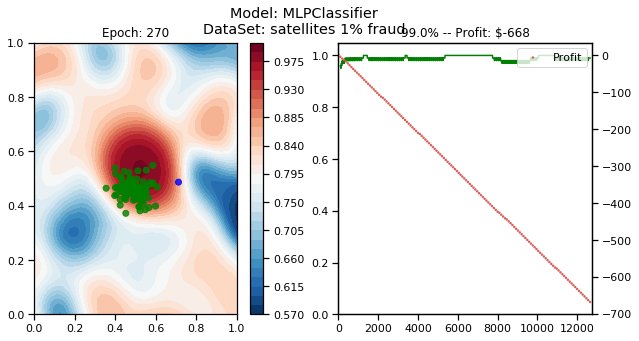

In [5]:
plot_history(pa_pipeline, pa_train_set, gen_name='satellites 1% fraud',
                    save_gif=False, trans=transformer, plot_cost=True)
plt.close()

In [15]:
plotter = Plotter()
plotter.plot_history(pa_pipeline, pa_train_set, gen_name='Satellites_test', save_gif=False, trans=transformer, plot_cost=True)

KeyboardInterrupt: 